This notebook goes throught the SIIM Dataset folders and creates csv files with the image file and its metadata.

In [1]:
import glob
import pydicom
import string
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from mask_functions import rle2mask

In [8]:
def show_dcm_info(dataset):
#     print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [3]:
# allImageDICOMsPaths = []

# for line in tuple(open('./input/siim/names.txt', 'r')):
#     dicomPath = './input/siim/dicom-images-train/' + line.strip('\n')
#     allImageDICOMsPaths.append(dicomPath)
    
# print('Total Paths specified: ', len(allImageDICOMsPaths))

In [3]:
allImageDICOMsPaths = []
for dicomPath in glob.glob('../input/siim/dicom-images-train/**/**/*.dcm'):
    allImageDICOMsPaths.append(dicomPath)
    
print('Total Paths found: ', len(allImageDICOMsPaths))
print('sample path: ' + allImageDICOMsPaths[0])

Total Paths found:  12089
sample path: ../input/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.11610.1517875233.906871/1.2.276.0.7230010.3.1.3.8323329.11610.1517875233.906870/1.2.276.0.7230010.3.1.4.8323329.11610.1517875233.906872.dcm


In [5]:
## Read masks from csv
encodedMasksCsv = pd.read_csv('../input/siim/train-rle.csv', names= ['ImageId', 'EncodedPixels'], index_col='ImageId')

# print some samples
encodedMasksCsv[:5]

,EncodedPixels
ImageId,
ImageId,EncodedPixels
1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819,-1
1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789,-1
1.2.276.0.7230010.3.1.4.8323329.10366.1517875223.393986,514175 10 1008 29 994 30 993 32 991 33 990 34 ...


In [6]:
# Read all DICOM files and load the ones with masks

## structure of allDicomWithMasks:
# [{
#     'masks': allMasksOfCurrent,
#     'data': dataset
# }]

allDicomWithMasks = []

allFailedPaths = []

im_height = 1024
im_width = 1024
im_chan = 1


# Just for reference
readingStatus = {}
readingStatus['success'] = 0
readingStatus['failed'] = 0
readingStatus['withMasks'] = 0
readingStatus['totalWithSingleMasks'] = 0
readingStatus['totalWithMultipleMasks'] = 0
readingStatus['withoutMasks'] = 0

for dPath in allImageDICOMsPaths:
    try:
        dataset = pydicom.dcmread(dPath)
        
        # get mask (in rle) from csv
        fileId = dPath.split('/')[-1][:-4]
        rle = encodedMasksCsv.loc[fileId, 'EncodedPixels']
#         print(type(rle) == str)
        
        # save only if mask exists
        if '-1' in rle: # if rle (encoded mask) not available
            readingStatus['withoutMasks'] = readingStatus['withoutMasks'] + 1
        else:
            allMasksOfCurrent = []
            try:
                if type(rle) == str: # if single rle
                    readingStatus['totalWithSingleMasks'] = readingStatus['totalWithSingleMasks'] + 1
                    
                    allMasksOfCurrent.append(rle2mask(rle, im_height, im_width))
                else: # if multiple rle
                    readingStatus['totalWithMultipleMasks'] = readingStatus['totalWithMultipleMasks'] + 1
                    for x in rle:
                        allMasksOfCurrent.append(rle2mask(x, im_height, im_width))
            except Exception as e:
                print(e)
                    
            readingStatus['withMasks'] = readingStatus['withMasks'] + 1
        
        
            allDicomWithMasks.append({
                'masks': allMasksOfCurrent,
                'data': dataset,
                'filePath': dPath,
                'encodedPixels': rle
            })
        
        readingStatus['success'] = readingStatus['success'] + 1
    except Exception as e:
        allFailedPaths.append(dPath)
        readingStatus['failed'] = readingStatus['failed'] + 1

    clear_output(wait=True)
    readingStatus['total'] = readingStatus['success'] + readingStatus['failed']
    print(readingStatus)

{'success': 12047, 'failed': 42, 'withMasks': 2669, 'totalWithSingleMasks': 2045, 'totalWithMultipleMasks': 624, 'withoutMasks': 9378, 'total': 12089}


Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: d5e12bed-fbda-4b27-9de7-606e928984d7, 
Patient id..........: d5e12bed-fbda-4b27-9de7-606e928984d7
Patient's Age.......: 40
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 148478 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


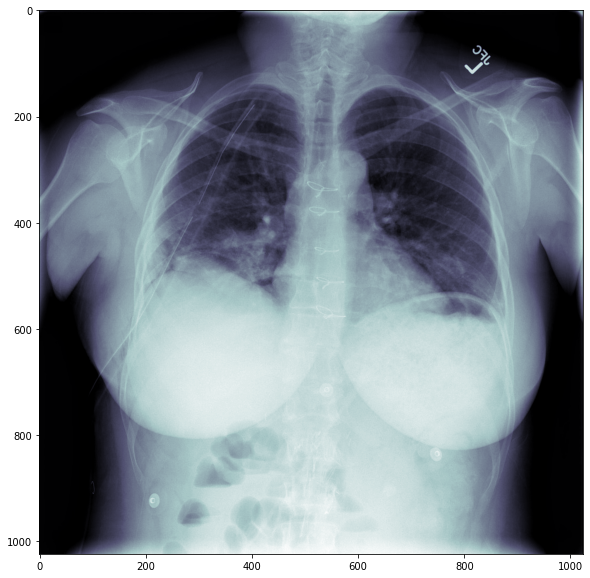

In [9]:
show_dcm_info(allDicomWithMasks[0]['data'])
plot_pixel_array(allDicomWithMasks[0]['data'])

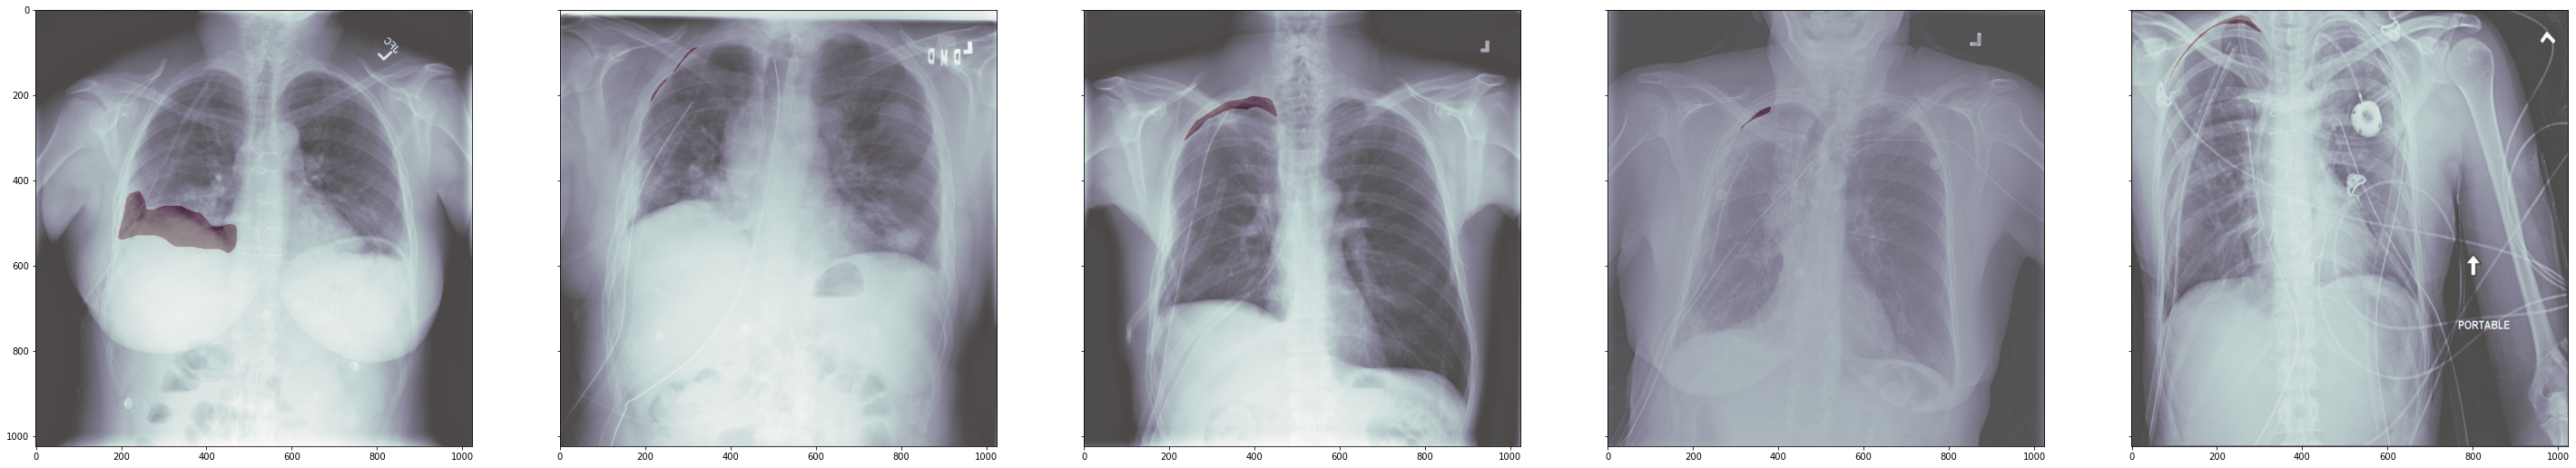

In [10]:
sampleImages = allDicomWithMasks[:5]
num_img = len(sampleImages)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for i in range(num_img):
    ax[i].imshow(sampleImages[i]['data'].pixel_array, cmap=plt.cm.bone)
    masks = sampleImages[i]['masks']
#     print(len(masks))
    for x in masks:
        ax[i].imshow(x.T, alpha=0.3, cmap="Reds")

In [11]:
# separate out only unique patients

## structure of uniqueDS:
# [{
#     'masks': allMasksOfCurrent,
#     'data': dataset
# }]

uniquePatientsDS = []
duplicatepatientsDS = []

patientIds = set()
for ds in allDicomWithMasks:
    pid = str(ds['data'].PatientID);
    if pid in patientIds:
        duplicatepatientsDS.append(ds)
    else:
        patientIds.add(pid)
        uniquePatientsDS.append(ds)
del patientIds # delete to save memory space

print('unique: ' + str(len(uniquePatientsDS)))
print('duplicates: ' + str(len(duplicatepatientsDS)))

unique: 2669
duplicates: 0


In [14]:
# save the file paths to .csv
# pDS = pd.DataFrame({'path' : [], 'encodedPixels': []})
# pDS = pd.DataFrame(columns = ['path' , 'encodedPixels'])
# for ds in uniquePatientsDS:
#     pDS = pDS.append({'path' : ds['filePath'], 'encodedPixels': ds['encodedPixels']}, ignore_index=True)
# pDS

pDS = pd.DataFrame(columns = ['path'])
for ds in uniquePatientsDS:
    pathStr = ds['filePath'].replace('../input/siim/', '')
    pDS = pDS.append({'path' : pathStr}, ignore_index=True)
pDS

,path
0,dicom-images-train/1.2.276.0.7230010.3.1.2.832...
1,dicom-images-train/1.2.276.0.7230010.3.1.2.832...
2,dicom-images-train/1.2.276.0.7230010.3.1.2.832...
3,dicom-images-train/1.2.276.0.7230010.3.1.2.832...
4,dicom-images-train/1.2.276.0.7230010.3.1.2.832...
...,...
2664,dicom-images-train/1.2.276.0.7230010.3.1.2.832...
2665,dicom-images-train/1.2.276.0.7230010.3.1.2.832...
2666,dicom-images-train/1.2.276.0.7230010.3.1.2.832...
2667,dicom-images-train/1.2.276.0.7230010.3.1.2.832...


In [16]:
pDS.to_csv(r'../input/siim/dataset-with-masks-rle.csv', index = None, header=True)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

# First dividing dataset into two chunks (Training and testing+validation)
train_features, test_val_features = train_test_split(
    pDS, test_size = 0.40, shuffle=True
);

# Now dividing testing+validation into test and validation
test_features, val_features = train_test_split(
    test_val_features, test_size = 0.50, shuffle=False
);


print('Total Dataset:', pDS.shape)
print('Training DS Shape:', train_features.shape)
# print('Training Labels Shape:', train_labels.shape)
print('Testing DS Shape:', test_features.shape)
# print('Testing Labels Shape:', test_labels.shape)
print('Validation DS Shape:', val_features.shape)

Total Dataset: (2669, 1)
Training DS Shape: (1601, 1)
Testing DS Shape: (534, 1)
Validation DS Shape: (534, 1)


In [19]:
## save the splitted DS to csv
train_features.to_csv(r'../input/siim/simm_DS_train.csv', index = None, header=True)
test_features.to_csv(r'../input/siim/simm_DS_test.csv', index = None, header=True)
val_features.to_csv(r'../input/siim/simm_DS_validation.csv', index = None, header=True)